# Feature based approach


In [6]:
#import libraries needed
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
# %matplotlib inline

### Data exploration

In [23]:
#training data for feature based approach
raw = pd.read_csv("/kaggle/input/csm6420-a2/train_feat.csv")
data = raw.fillna(value=0)
print(f"Training Data: {data.info()}")
# print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Columns: 190 entries, ID to F187
dtypes: float64(188), object(2)
memory usage: 18.9+ MB
Training Data: None


In [24]:
X = data.iloc[:,2:]
y = data['Type']

In [25]:
# different labels
diff_types = set(y)
print(diff_types)

{'~', 'A', 'O', 'N'}


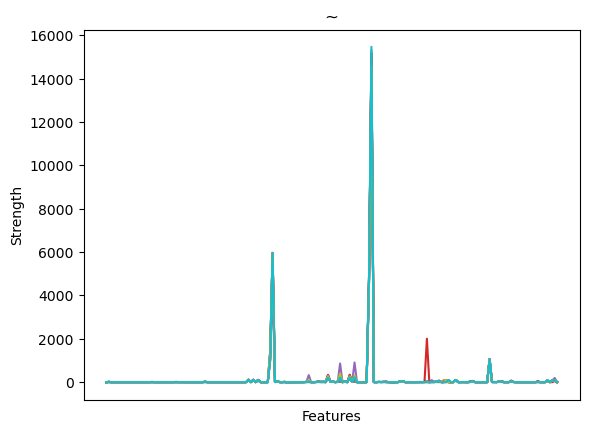

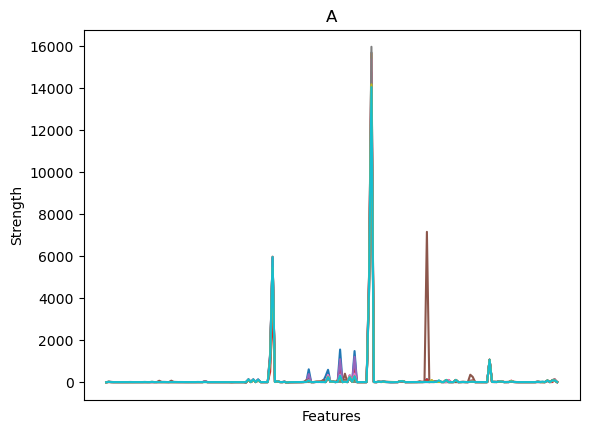

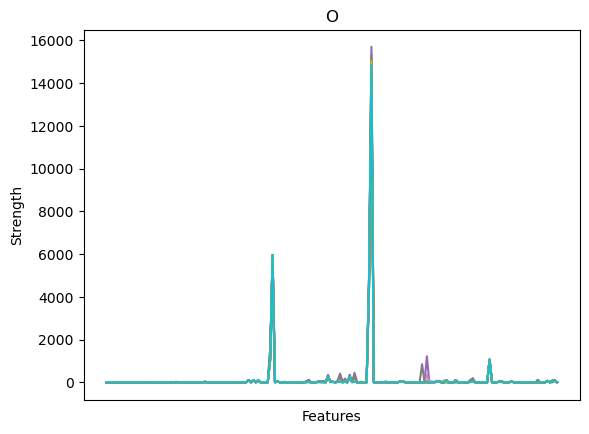

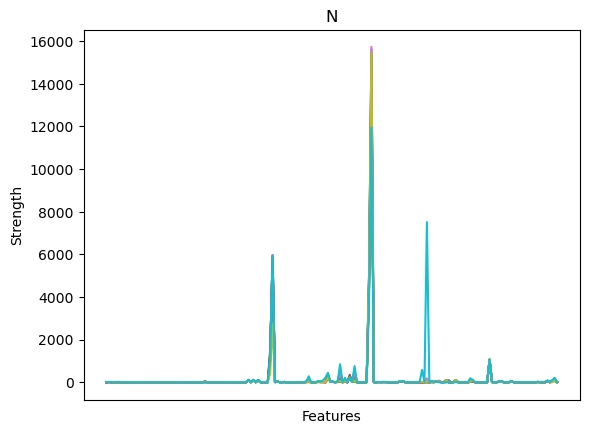

In [31]:
import random
for tpe in diff_types:
    plt.clf()
    for i in range(10):
        index = random.randint(1, 100)
        first_instance = data.loc[data.Type == tpe].iloc[index]
        feats = first_instance.drop(['Type', 'ID'])
        feats.plot()
    plt.xticks([])
    plt.xlabel("Features")
    plt.ylabel("Strength")
    plt.title(tpe)
    plt.show()

In [ ]:
variation =  data.groupby('Type').var()
plt.bar(variation.columns, variation.max())
variation.max().max()

# PreProcess data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6420, stratify = y)

In [ ]:
# x and y train data
from sklearn import preprocessing

#extract features and labels

#encode labels to 0, 1, 2, 3
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(np.unique(y_train_encoded))
print(label_encoder.inverse_transform(np.unique(y_train_encoded)))

# Encoded values:

- 0 = A
- 1 = N
- 2 = O
- 3 = ~

In [ ]:
#visualise distribution of class labels
data.Type.value_counts().plot(kind='bar')

## resample data to balance out the labels

In [ ]:
#resample data to balance labels
from sklearn.utils import resample
x_train['label'] = y_train_encoded
unbalanced = x_train

Ns = unbalanced[unbalanced.label == 1]
Os = unbalanced[unbalanced.label == 2]
As = unbalanced[unbalanced.label == 0]
noisy = unbalanced[unbalanced.label == 3]

print("N length: ", len(Ns))
print("O length: ", len(Os))
print("A length: ", len(As))
print("Noisy length: ", len(noisy))

avg = np.mean((len(Ns),len(Os) ,len(As)))

balanced_N = resample(Ns, n_samples = int(avg), replace=False)
balanced_O = resample(Os, n_samples = int(avg), replace=True)
balanced_A = resample(As, n_samples = int(avg), replace=True)
balanced_noise = resample(noisy, n_samples = int(avg), replace=True)
print("~~~~~~~~~~~~~~~~~~~~")
print("N balanced length: ", len(balanced_N))
print("O balanced length: ", len(balanced_O))
print("A balanced length: ", len(balanced_A))
print("Noisy length: ", len(noisy))

balanceddf = pd.concat([balanced_N, balanced_O,balanced_A, noisy])
print(balanceddf.label.value_counts())

balanceddf.label.value_counts().plot(kind='bar')

In [ ]:
print(balanceddf.head(1))

# Test and train data:

In [ ]:
x_train_balanced = balanceddf.drop(columns=['label'])
y_train_balanced = balanceddf.label
print(x_train_balanced.shape)
print(y_train_balanced.shape)
print(y_train_balanced.value_counts())

In [ ]:
print(x_test.shape)
print(y_test.shape)
print(y_test.value_counts())

In [ ]:
print(x_train_balanced.columns)

# Normlise data with standard scaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

# PCA dimenionality reduction

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()

In [ ]:
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

# normalise data with minmax scaler

- fit pca the same as above

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

# Modelling Experiments

fit un processed data to models

In [ ]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

random_seed = 6420
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_seed)

hist = {}


In [ ]:
print(x_train.columns)
print(x_test.columns)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def report(clf):
    clf.fit(x_train_balanced, y_train_balanced)
    pred = clf.predict(x_test)
    out = label_encoder.inverse_transform(pred)
    report = classification_report(y_test, out, output_dict=True)
    f1 = report['weighted avg']['f1-score']
#     print('confusion matrix:\n',confusion_matrix(y_test, out))
#     print('\n\nclassification report:\n',report)
    print(f'=={clf}==\nweighted f1 score = {f1}')
    return f1

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tree_params = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [1, 10, 25, 50, None],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

grid = GridSearchCV(RandomForestClassifier(),
                         tree_params, cv=cross_val, scoring='f1_weighted',
                         verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['random_forest'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Naive Bayes
Use gaussian naive bayes as data is not binomial

In [ ]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes_grid = [{'var_smoothing': np.logspace(0,-9, 100)}]
grid = GridSearchCV(bayes,bayes_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=0, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['Bayes'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

knn = KNeighborsClassifier()

knn_grid = {'n_neighbors': range(1, 50, 5),
           'weights': ['uniform', 'distance'],
           'algorithm': ['ball_tree', 'kd_tree', 'brute']
           }

grid = GridSearchCV(knn,knn_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['knn'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Dimensionality Reduction and data scaling experiments

- Creating piplines for data standardising and dimensionality reduction

# Random forests 

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe = Pipeline(steps = [('scale', 'passthrough'),
                         ('reduce_dim', PCA()),
                         ('clf', RandomForestClassifier(random_state=6420))])

pipe_params = [
    {
        'scale': [StandardScaler()],
        'reduce_dim__n_components': ['mle', 63, 85, 125],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [1, 10, 25, 50],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', 'log2']
    },
    {
        'scale': [MinMaxScaler()],
        'reduce_dim__n_components': ['mle', 33, 53, 96],
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [1, 10, 25, 50],
        'clf__criterion': ['gini', 'entropy'],
        'clf__max_features': ['sqrt', 'log2']
    }
]

grid = GridSearchCV(pipe,pipe_params, cv=cross_val, scoring='f1_weighted', verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)

hist['Rf_PCA'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")

# Signal based end-to-end approach

## Data exploration

In [4]:
import tensorflow as tf
from tensorflow import keras

In [7]:
signal = pd.read_csv('/kaggle/input/csm6420-a2/train_signal.csv')
print(signal.head(1))

       ID Type     X0   X1     X2     X3     X4     X5     X6     X7  ...  \
0  B00000    N -0.107 -0.1 -0.086 -0.078 -0.071 -0.057 -0.049 -0.035  ...   

   X5990  X5991  X5992  X5993  X5994  X5995  X5996  X5997  X5998  X5999  
0 -1.108 -1.072 -1.028 -0.978 -0.912 -0.862 -0.804 -0.724  -0.63 -0.499  

[1 rows x 6002 columns]


In [70]:
print(signal.describe())

                 X0            X1            X2            X3            X4  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.002608      0.008771      0.015139      0.020327      0.024067   
std        1.444359      1.670797      1.907979      2.141337      2.329631   
min      -15.899000    -18.809000    -21.489000    -23.777000    -25.310000   
25%       -0.504750     -0.535000     -0.561750     -0.578000     -0.587000   
50%       -0.076500     -0.079000     -0.080000     -0.081000     -0.083000   
75%        0.466000      0.507000      0.543000      0.576000      0.606750   
max       16.082000     16.051000     17.947000     19.322000     19.578000   

                 X5            X6            X7            X8            X9  \
count  13062.000000  13062.000000  13062.000000  13062.000000  13062.000000   
mean       0.024725      0.023264      0.021561      0.019900      0.018962   
std        2.420211      2.424005      2.392944    

In [72]:
print(signal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Columns: 6002 entries, ID to X5999
dtypes: float64(6000), object(2)
memory usage: 598.1+ MB
None


In [13]:
y = signal['Type']
unique_types = set(y)

print(unique_types)

{'A', 'O', 'N', '~'}


In [43]:
# how unbalanced are the labels
print(signal.Type.value_counts())

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

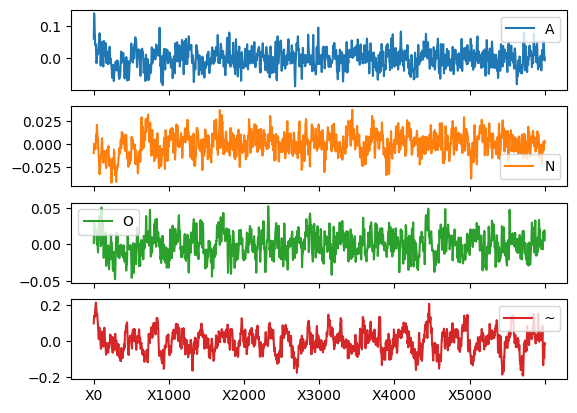

In [50]:
grouped = signal.groupby(['Type']).mean()
grouped.T.plot.line(subplots=True)

In [68]:
nans = signal.isna().sum().sum()
print(f'Total missing values: {nans}')

Total missing values: 815955


# Preprocess data

In [144]:
y = signal.Type

In [145]:
# replace missing values with 0 -> as if its just a 0 reading
no_missing = signal.fillna(0)

In [146]:
clean_X = no_missing.drop(['ID', 'Type'], axis=1)

In [155]:
# scale data between -1 and 1 per each row
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(clean_X.T)

scaled_data=pd.DataFrame(scaler.fit_transform(clean_X.T).T,columns=clean_X.columns)
print(scaled_data.head(1))

         X0        X1        X2       X3        X4        X5        X6  \
0 -0.562508 -0.560756 -0.557252 -0.55525 -0.553498 -0.549994 -0.547991   

         X7        X8        X9  ...    X5990    X5991     X5992     X5993  \
0 -0.544488 -0.542736 -0.538981  ... -0.81304 -0.80403 -0.793017 -0.780503   

      X5994    X5995     X5996     X5997     X5998     X5999  
0 -0.763984 -0.75147 -0.736954 -0.716932 -0.693405 -0.660618  

[1 rows x 6000 columns]


In [156]:
scaled_data['Type'] = y
print(scaled_data.head(1))

         X0        X1        X2       X3        X4        X5        X6  \
0 -0.562508 -0.560756 -0.557252 -0.55525 -0.553498 -0.549994 -0.547991   

         X7        X8        X9  ...    X5991     X5992     X5993     X5994  \
0 -0.544488 -0.542736 -0.538981  ... -0.80403 -0.793017 -0.780503 -0.763984   

     X5995     X5996     X5997     X5998     X5999  Type  
0 -0.75147 -0.736954 -0.716932 -0.693405 -0.660618     N  

[1 rows x 6001 columns]


Text(0.5, 1.0, 'N')

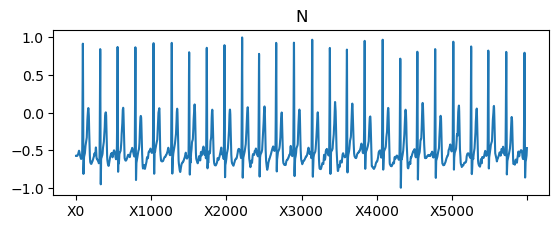

In [157]:
first_instance = scaled_data.iloc[686]
first_instance.drop(['Type']).plot()
plt.gca().set_aspect(1000)
plt.title(first_instance.Type)

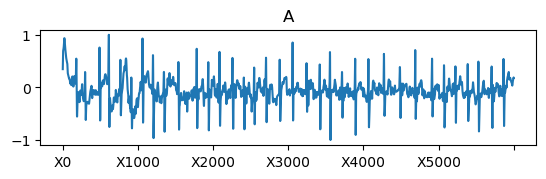

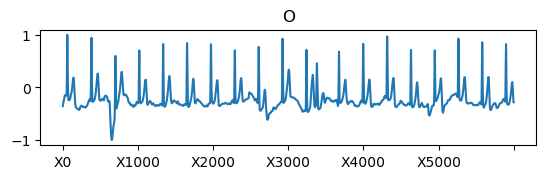

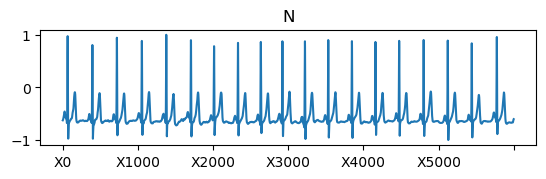

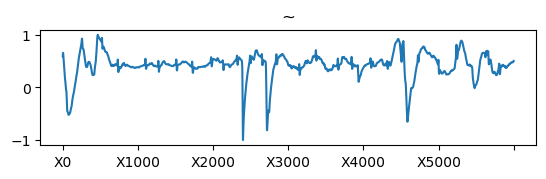

In [169]:
import random
for tpe in unique_types:
    plt.clf()
    for i in range(1):
        index = random.randint(1, 300)
        first_instance = scaled_data.loc[scaled_data.Type == tpe].iloc[index]
        feats = first_instance.drop(['Type'])
        feats.plot() 
    plt.gca().set_aspect(700)
    plt.title(tpe)
    plt.show()

In [ ]:
# resample data using SMOTE 



# Submission

In [159]:
def submit(clf):
    submission = pd.read_csv("/kaggle/input/csm6420-a2/test_feat.csv")
    print(submission.head(1))
    nan = submission.fillna(value=0)
    ids = nan.ID
    submission_data = nan.drop(columns='ID')
    predictions = clf.predict(submission_data)
    out = label_encoder.inverse_transform(predictions)
    submission_dict = {"ID": ids, "Predicted": out}
    final = pd.DataFrame.from_dict(submission_dict)
    final.to_csv(f"submission.csv", index=False)

In [160]:
best_train_score = 0
best_test_score = 0
submission_clf = None
for clf in hist:
    test_f1 = report(hist[clf].best_estimator_)
    if test_f1 > best_test_score:
        best_test_score = test_f1
        submission_clf = hist[clf].best_estimator_
        best_train_score = hist[clf].best_score_

print(f"****\n\nBest Classifier = {submission_clf}\n\nTest Score = {best_test_score:.5f} \n\nTrain Score = {best_train_score:.5f}")
submit(submission_clf)

NameError: name 'hist' is not defined